# A YELP RATINGS CLASSIFICATION PROJECT

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [161]:
yelp_train=pd.read_csv("/Users/howardyan/Desktop/Classes Spring 2021/IEOR 142 HW/Assignment_3_export/yelp142_test.csv")

In [162]:
yelp_test=pd.read_csv("/Users/howardyan/Desktop/Classes Spring 2021/IEOR 142 HW/Assignment_3_export/yelp142_train.csv")

## I attempt a regression model and analyze its predictive strength (OSR^2)

I now build a regression using yelp_train, but with modification to account for missing values

In [6]:
reg=smf.ols('stars ~ review_count+C(GoodForKids, Treatment(reference="(Missing)"))+C(Alcohol, Treatment(reference="(Missing)"))+C(BusinessAcceptsCreditCards, Treatment(reference="(Missing)"))+C(WiFi, Treatment(reference="(Missing)"))+C(BikeParking, Treatment(reference="(Missing)"))+C(ByAppointmentOnly, Treatment(reference="(Missing)"))+C(WheelechairAccessible, Treatment(reference="(Missing)"))+C(OutdoorSeating, Treatment(reference="(Missing)"))+C(RestaurantsReservations, Treatment(reference="(Missing)"))+C(DogsAllowed, Treatment(reference="(Missing)"))+C(Caters, Treatment(reference="(Missing)"))',data=yelp_train).fit()

In [7]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     25.16
Date:                Mon, 15 Mar 2021   Prob (F-statistic):          9.16e-104
Time:                        22:37:03   Log-Likelihood:                -3084.3
No. Observations:                2688   AIC:                             6221.
Df Residuals:                    2662   BIC:                             6374.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

## To select the best ccp_alpha for my decision tree, we employ grid search

Our datasets are already split. So we will define x_train and y_train here by subsetting our yelp_train set

In [110]:
x_train = pd.get_dummies(yelp_train.drop(['stars'], axis=1))
y_train= yelp_train['stars']

For the below cell, we find out ccp_alpha score by searching along the interval [0,0.1]. I initially chose [0,0.001] and received an interval limit as the optimal value, so I extended it.

In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

grid_values = {'ccp_alpha': np.linspace(0, 0.1, 51)}

tree = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)
cv = KFold(n_splits=5,random_state=1,shuffle=True) 
tree_cv = GridSearchCV(tree, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
tree_cv.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                             min_samples_split=20,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
       0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
       0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
       0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
       0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  ])},
             scoring='r2')

I plot the value here in the following graph and observe that the optimal ccp_alpha value is 0.004 given it has the highest CV R^2.

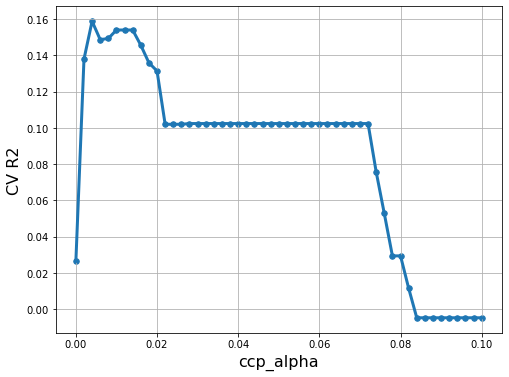

In [112]:
ccp_alpha = tree_cv.cv_results_['param_ccp_alpha'].data
R2_scores = tree_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(ccp_alpha, R2_scores, s=30)
plt.plot(ccp_alpha, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [113]:
tree_cv.best_params_

{'ccp_alpha': 0.004}

And now I will build the regression tree using CART. I begin by importing packages.

In [114]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [140]:
tree = DecisionTreeRegressor(min_samples_leaf=5, 
                              ccp_alpha=0.004,
                              random_state = 88)

In [141]:
tree = tree.fit(x_train,y_train)

Now, I'll print the tree

Node count = 13


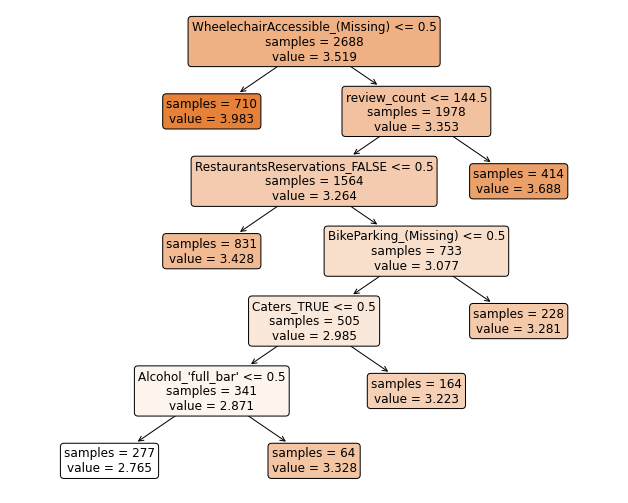

In [152]:
print('Node count =', tree.tree_.node_count)
plt.figure(figsize=(11,9))
plot_tree(tree, 
  feature_names=x_train.columns, 
  class_names=['0','1'], 
  filled=True,
  impurity=False,
  rounded=True,
  fontsize=12) 
plt.show()


## And now I'll look at our OSR^2

Arrange x_test, y_test, and y_train

OSR2 score of the decision tree

In [153]:
x_test = pd.get_dummies(yelp_test.drop(['stars'], axis=1))

In [154]:
y_test=yelp_test['stars']

In [155]:
def OSR2(model, x_test, y_test, y_train):
    
    y_pred = model.predict(x_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [156]:
OSR2(tree_cv,x_test,y_test,y_train)

0.13679718209884095

OSR2 score of the linear regression model

In [187]:
TSS=sum((y_test-np.mean(y_test))**2)

In [188]:
RSS=sum((y_test-reg.predict(yelp_test))**2)

In [194]:
1-(RSS/TSS)

0.14883006943627353

Calculate MAE of the regression tree model

In [23]:
from sklearn.metrics import mean_absolute_error

In [190]:
mean_absolute_error(y_test,tree_cv.predict(x_test))

0.6211612278598578

Calculate MAE of the regression statsmodel

In [191]:
mean_absolute_error(yelp_test[['stars']],reg.predict(yelp_test))

0.6244015758299649

## It appears a classification model might be a better choice. I'll Explore this now, and begin by creating dummy varibles for my dataset.

First, perform this on the training set

In [164]:
yelp_train['fourOrabove']=pd.Series([1 if x >= 4 else 0 for x in y_train], index=y_train.index)
yelp_train

,stars,review_count,GoodForKids,Alcohol,BusinessAcceptsCreditCards,WiFi,BikeParking,ByAppointmentOnly,WheelechairAccessible,OutdoorSeating,RestaurantsReservations,DogsAllowed,Caters,fourOrabove
0,4.5,11,(Missing),(Missing),TRUE,(Missing),(Missing),(Missing),(Missing),(Missing),FALSE,(Missing),(Missing),1
1,4.0,82,TRUE,'none',TRUE,'no',TRUE,(Missing),TRUE,FALSE,FALSE,(Missing),TRUE,1
2,5.0,3,(Missing),(Missing),TRUE,'no',TRUE,TRUE,TRUE,(Missing),(Missing),FALSE,(Missing),1
3,4.0,141,TRUE,'none',TRUE,'no',FALSE,(Missing),TRUE,FALSE,FALSE,(Missing),TRUE,1
4,5.0,222,TRUE,'none',TRUE,'free',TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,2.5,33,TRUE,'none',TRUE,'no',TRUE,(Missing),(Missing),FALSE,FALSE,(Missing),TRUE,0
2684,4.0,19,FALSE,'full_bar',TRUE,'no',TRUE,(Missing),(Missing),FALSE,FALSE,(Missing),FALSE,1
2685,4.5,182,TRUE,'none',TRUE,'free',TRUE,(Missing),TRUE,FALSE,FALSE,FALSE,FALSE,1
2686,5.0,4,(Missing),(Missing),(Missing),(Missing),(Missing),(Missing),(Missing),(Missing),(Missing),(Missing),(Missing),1


And now on the test set

In [165]:
yelp_test['fourOrabove']=pd.Series([1 if x >= 4 else 0 for x in y_test], index=y_test.index)
yelp_test

,stars,review_count,GoodForKids,Alcohol,BusinessAcceptsCreditCards,WiFi,BikeParking,ByAppointmentOnly,WheelechairAccessible,OutdoorSeating,RestaurantsReservations,DogsAllowed,Caters,fourOrabove
0,3.5,26,(Missing),(Missing),TRUE,(Missing),TRUE,(Missing),(Missing),(Missing),(Missing),(Missing),(Missing),0
1,3.0,40,TRUE,'full_bar',TRUE,'free',FALSE,(Missing),(Missing),TRUE,FALSE,(Missing),(Missing),0
2,4.5,45,TRUE,'full_bar',TRUE,'free',FALSE,(Missing),(Missing),TRUE,FALSE,(Missing),(Missing),1
3,4.5,61,TRUE,(Missing),TRUE,(Missing),(Missing),(Missing),(Missing),FALSE,(Missing),(Missing),FALSE,1
4,3.5,5,TRUE,'beer_and_wine',TRUE,(Missing),(Missing),(Missing),(Missing),FALSE,FALSE,(Missing),(Missing),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6267,4.5,132,TRUE,'beer_and_wine',TRUE,'no',TRUE,(Missing),TRUE,FALSE,FALSE,FALSE,TRUE,1
6268,5.0,27,(Missing),'none',TRUE,'no',TRUE,(Missing),TRUE,FALSE,FALSE,FALSE,TRUE,1
6269,4.5,149,(Missing),'none',FALSE,(Missing),TRUE,FALSE,(Missing),(Missing),(Missing),(Missing),TRUE,1
6270,3.0,52,(Missing),(Missing),TRUE,(Missing),TRUE,FALSE,(Missing),(Missing),(Missing),(Missing),FALSE,0


Here we threshold the prediction for the statsmodel regression at 4

In [28]:
reg_pred=reg.predict(yelp_test)
reg_pred=pd.Series([1 if x >= 4 else 0 for x in reg_pred], index=reg_pred.index)
reg_pred

0       0
1       0
2       0
3       0
4       0
       ..
6267    1
6268    0
6269    0
6270    0
6271    0
Length: 6272, dtype: int64

Here we threshold the prediction for the decision tree at 4

In [29]:
tree_pred=tree_cv.predict(x_test)
tree_pred=pd.Series(tree_pred)
tree_pred=pd.Series([1 if x >= 4 else 0 for x in tree_pred],index=tree_pred.index)
tree_pred

0       0
1       0
2       0
3       0
4       0
       ..
6267    0
6268    0
6269    0
6270    0
6271    0
Length: 6272, dtype: int64

In [30]:
max(tree_cv.predict(x_test))

3.983098591549296

## Now, I'll build the logistic model 

In [31]:
x_test = pd.get_dummies(yelp_test.drop(['fourOrabove','stars'], axis=1))
y_test= yelp_test['fourOrabove']

In [32]:
logit=smf.logit('fourOrabove~ review_count+C(GoodForKids, Treatment(reference="(Missing)"))+C(Alcohol, Treatment(reference="(Missing)"))+C(BusinessAcceptsCreditCards, Treatment(reference="(Missing)"))+C(WiFi, Treatment(reference="(Missing)"))+C(BikeParking, Treatment(reference="(Missing)"))+C(ByAppointmentOnly, Treatment(reference="(Missing)"))+C(WheelechairAccessible, Treatment(reference="(Missing)"))+C(OutdoorSeating, Treatment(reference="(Missing)"))+C(RestaurantsReservations, Treatment(reference="(Missing)"))+C(DogsAllowed, Treatment(reference="(Missing)"))+C(Caters, Treatment(reference="(Missing)"))',yelp_train).fit()

Optimization terminated successfully.
         Current function value: 0.605269
         Iterations 6


In [197]:
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:            fourOrabove   No. Observations:                 2688
Model:                          Logit   Df Residuals:                     2662
Method:                           MLE   Df Model:                           25
Date:                Mon, 15 Mar 2021   Pseudo R-squ.:                  0.1207
Time:                        23:08:12   Log-Likelihood:                -1627.0
converged:                       True   LL-Null:                       -1850.4
Covariance Type:            nonrobust   LLR p-value:                 7.377e-79
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -0.4333   

In [33]:
log_results=logit.predict(yelp_test)

## I set the threshold at 0.5 (this is the optimal level from Naive Baye's Classifier)

In [34]:
log_results
log_results=pd.Series([1 if x >= 0.5 else 0 for x in log_results], index=log_results.index)

In [35]:
confusion_matrix(y_test,log_results)

array([[2787,  744],
       [1335, 1406]])

In [36]:
logit_Acc=(2787+1406)/(2787+744+1335+1406)

In [37]:
logit_TPR=1406/(1406+1335)

In [38]:
logit_FPR=744/(744+2787)

## Now I'll see if I can do better and build a decision tree classifier

In [159]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 

In [166]:
x_train = pd.get_dummies(yelp_train.drop(['stars','fourOrabove'], axis=1))
y_train = yelp_train[['fourOrabove']]

First we will use cross validation to identify the ccp alpha, but note that we're using a decision tree classifier rather than regressor

In [170]:
from sklearn.model_selection import GridSearchCV

grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'class_weight' : [{0: 1, 1: 20}],
               'random_state': [88]} 
            
dtc = DecisionTreeClassifier()
dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=10, verbose=1) 
dtc_cv_acc.fit(x_train, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2010 out of 2010 | elapsed:   23.2s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.02...
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'class_weight': [{0: 1, 1: 20}], 'max_depth': [30],
                         'min_samples_leaf': [5], 'min_samples_split': [20],
                         'random_state': [88]},
             scoring='acc

In [171]:
acc = dtc_cv_acc.cv_results_['mean_test_score'] 
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy': acc}).head(20)

,ccp alpha,Validation Accuracy
0,0,0.513756
1,0.0005,0.490699
2,0.001,0.451265
3,0.0015,0.451265
4,0.002,0.451265
5,0.0025,0.451265
6,0.003,0.451265
7,0.0035,0.451265
8,0.004,0.451265
9,0.0045,0.451265


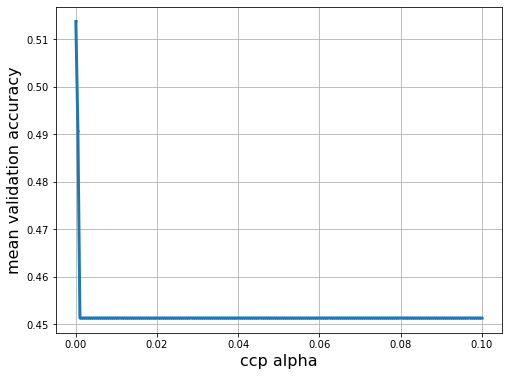

In [172]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [173]:
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. accuracy):  0.0
Grid best score (accuracy):  0.513756033956611


Node count = 461


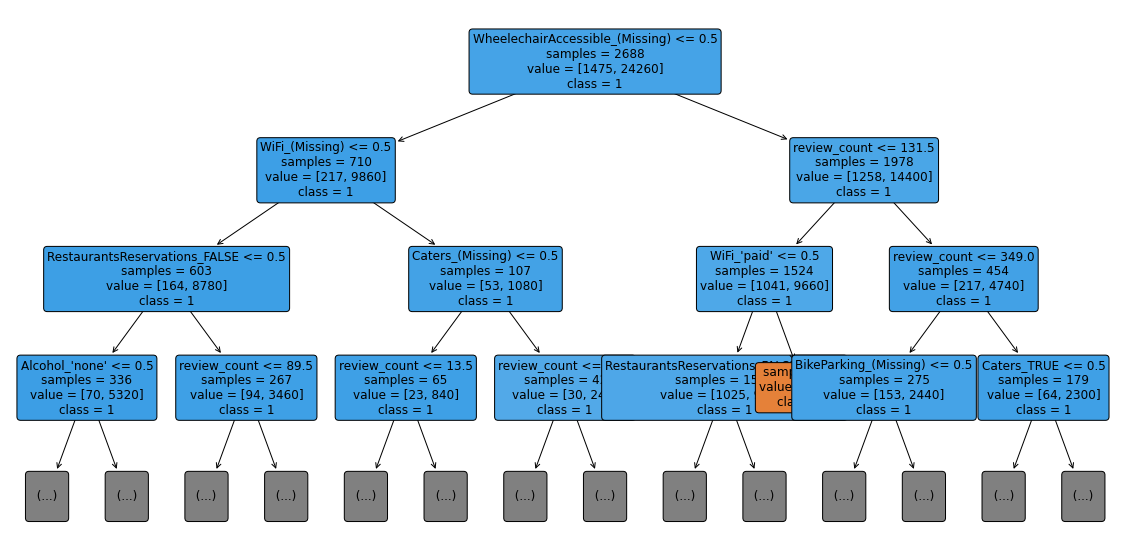

In [174]:
print('Node count =', dtc_cv_acc.best_estimator_.tree_.node_count)

plt.figure(figsize=(20,10))
plot_tree(dtc_cv_acc.best_estimator_, 
          feature_names=x_train.columns, 
          class_names=['0','1'],
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()


In [46]:
class_tree = DecisionTreeClassifier(min_samples_leaf=5, 
                              ccp_alpha=0,
                              random_state = 88)

In [47]:
class_tree=class_tree.fit(x_train,y_train)

In [48]:
confusion_matrix(y_test,class_tree.predict(x_test))

array([[2528, 1003],
       [1306, 1435]])

In [49]:
sum(sum(confusion_matrix(y_test,class_tree.predict(x_test))))

6272

In [50]:
class_tree_acc=(2528+1435)/sum(sum(confusion_matrix(y_test,class_tree.predict(x_test))))
class_tree_acc

0.6318558673469388

In [51]:
class_tree_TPR=1435/(1435+1306)

In [52]:
class_tree_FPR=1003/(1003+2528)

## I'll Try Bagging (Bootstrapping) Too!

In [53]:
pd.get_dummies(yelp_train.drop(['review_count','fourOrabove'], axis=1))

,stars,GoodForKids_(Missing),GoodForKids_FALSE,GoodForKids_TRUE,Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_(Missing),BusinessAcceptsCreditCards_(Missing),BusinessAcceptsCreditCards_FALSE,...,OutdoorSeating_TRUE,RestaurantsReservations_(Missing),RestaurantsReservations_FALSE,RestaurantsReservations_TRUE,DogsAllowed_(Missing),DogsAllowed_FALSE,DogsAllowed_TRUE,Caters_(Missing),Caters_FALSE,Caters_TRUE
0,4.5,1,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
1,4.0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2,5.0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
3,4.0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
4,5.0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,2.5,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2684,4.0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2685,4.5,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2686,5.0,1,0,0,0,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0


In [54]:
x_train = pd.get_dummies(yelp_train.drop(['fourOrabove','stars'],axis=1))
y_train = yelp_train['fourOrabove']

In [55]:
x_test = pd.get_dummies(yelp_test.drop(['fourOrabove','stars'], axis=1))
y_test= yelp_test['fourOrabove']

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features=36, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=0);
rf.fit(x_train, y_train)

RandomForestClassifier(max_features=36, min_samples_leaf=5, n_estimators=500,
                       random_state=88)

In [57]:
rf.verbose = False

print('OSR2:', round(OSR2(rf, x_test, y_test, y_train), 5))

OSR2: -0.33774


Now, find the TPR and FPR using a confusion matrix

In [58]:
cm = confusion_matrix(y_test, rf.predict(x_test))
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[2679  852]
 [1214 1527]]


In [59]:
Vanilla_Accuracy=(2679+1527)/(2679+852+1214+1527)
Vanilla_Accuracy

0.6705994897959183

In [60]:
Vanilla_TPR=1527/(1527+1214)
Vanilla_TPR

0.5570959503830719

In [61]:
Vanilla_FPR=852/(852+2679)
Vanilla_FPR

0.2412914188615123

## Now, I'll use a random forest to see if I can do better than my tree...

Here, we will use a random forest model classifier and use cross validation to find the ideal number of features. 

The following code takes a long time to compute 

In [62]:
import time

grid_values = {'max_features': np.linspace(1,36,36, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestClassifier() 

cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(x_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.7s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.7s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.7s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.7s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.7s
[CV] max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.7s
[CV] max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.8s
[CV] max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.9min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=333, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36], dtype=int32),
                         'min_samples_leaf': [5], 'n_estimators': [500],
                         'random_state': [88]},
             scoring='r2', verbose=2)

Interestingly, our OSR^2 value is negative. This may happen when there is no accompanying intercept (but GSI in OH confirms this is fine as long as we have high accuracy)

(-0.4, -0.25)

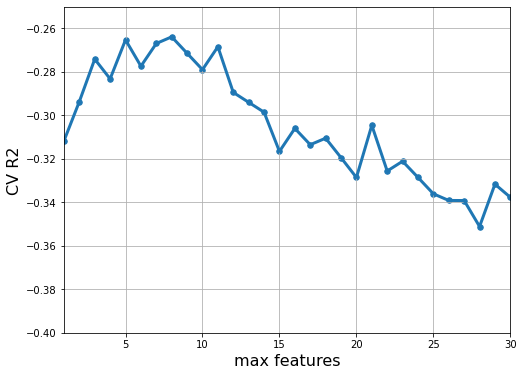

In [63]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')
plt.xlim([1, 30])
plt.ylim([-0.4, -0.25])

In [64]:
print(rf_cv.best_params_)

{'max_features': 8, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


Now we build a random forest model using the max features selected for us

In [65]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features=8, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=0);
rf.fit(x_train, y_train);

In [66]:
rf.verbose = False

print('OSR2:', round(OSR2(rf, x_test, y_test, y_train), 5))

OSR2: -0.29436


And now we will build a confusion matrix to calcualte the TPR, FPR, and other metrics

In [67]:
cm = confusion_matrix(y_test, rf.predict(x_test))
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[2771  760]
 [1239 1502]]


In [68]:
Forest_Accuracy=sum(rf.predict(x_test)==y_test)/len(y_test)
Forest_Accuracy

0.681281887755102

In [69]:
Forest_FPR=760/(760+2771)
Forest_FPR

0.21523647691871992

In [70]:
Forest_TPR=1502/(1239+1502)
Forest_TPR

0.5479751915359358

## Now, I'll build a comparison table

## Step 1: The baseline

First we will build the baseline model where we assume every restaurant shares the most common rating (four star/above or not). The below code indicates only 45% of restaurants have ratings that are four stars or above. Therefore, we predict every restaurant is not fourorabove.

In [71]:
sum(yelp_train['fourOrabove'])/len(yelp_train['fourOrabove'])

0.45126488095238093

In [72]:
baseline=np.zeros(len(yelp_test))
baseline

array([0., 0., 0., ..., 0., 0., 0.])

In [73]:
cm = confusion_matrix(y_test, baseline)
cm

array([[3531,    0],
       [2741,    0]])

In [74]:
Baseline_Accuracy=3531/(2741+3531)
Baseline_Accuracy

0.5629783163265306

In [75]:
B_TPR=0
B_FPR=0

## Recall the decision tree and statsmodel predictions

In [76]:
## Regression Statsmodels
reg_pred
confusion_matrix(y_test,reg_pred)

array([[3339,  192],
       [2152,  589]])

In [77]:
stats_acc=(3339+589)/(3339+589+192+2152)
stats_acc

0.6262755102040817

In [78]:
stats_TPR=589/(589+2152)
stats_FPR=(192)/(3339+192)

In [79]:
print(stats_TPR)
print(stats_FPR)

0.21488507843852608
0.05437553101104503


In [80]:
## Regression Tree
tree_pred
confusion_matrix(y_test, tree_pred)

array([[3531,    0],
       [2741,    0]])

In [81]:
Tree_Acc=3531/(3531+2741)

In [82]:
Tree_TPR=0

In [83]:
Tree_FPR=0

## And now, we collate our findings

In [200]:
findings= pd.DataFrame({'Accuracy': [Baseline_Accuracy, stats_acc, Tree_Acc, logit_Acc , class_tree_acc,Vanilla_Accuracy, Forest_Accuracy],
                   'TPR': [B_TPR, stats_TPR, Tree_TPR, logit_TPR, Vanilla_TPR, class_tree_TPR, Forest_TPR],
                   'FPR': [B_FPR, stats_FPR, Tree_FPR, logit_FPR, Vanilla_FPR, class_tree_FPR, Forest_FPR]},
                  index=['Baseline', 'Statsmodel Regression', 'Regression Tree','Logistic Regression for Classification','Classification Tree','Vanilla Bagging Tree','Random Forest Classifier'])

In [201]:
findings

,Accuracy,TPR,FPR
Baseline,0.562978,0.000000,0.000000
Statsmodel Regression,0.626276,0.214885,0.054376
Regression Tree,0.562978,0.000000,0.000000
Logistic Regression for Classification,0.668527,0.512951,0.210705
Classification Tree,0.631856,0.557096,0.241291
Vanilla Bagging Tree,0.670599,0.523532,0.284056
Random Forest Classifier,0.681282,0.547975,0.215236


## Part E

### My three tips
1) Ensure your restaurant does not permit dogs. It is reasonable to anticipate patrons do not want to dine in a messy or loud environment. The importance score ascribed to this is a 4.4%, which is quite high compared to the other features we've listed. The p-value of this variable when we run a logistic regression is virtually 0, meaning this plays a significant role in improving your stars for many restaurants in Las Vegas.

2) Make sure your restaurant is wheelchair accessible so you may appeal to a wider customer base. This feature has a 6.7% importance score. The p-value here is also near 0, so this plays a significant role in obtaining higher ratings for other restaurants in the Las Vegas area.

3) Be available for catering. This has a 2.8% importance score, and the associated p-value is also quite low (0.006). This may be a great way to expand your brand name and reach by providing for socials/other events. 

### The Data and Analysis

###  Simplest method: show a list of feature importance

In [210]:
importance=pd.DataFrame({'Feature' : x_train.columns,  
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)
importance

,Feature,Importance score
0,review_count,22.8
1,GoodForKids_(Missing),1.2
2,GoodForKids_FALSE,1.1
3,GoodForKids_TRUE,2.1
4,Alcohol_'beer_and_wine',1.1
5,Alcohol_'full_bar',1.8
6,Alcohol_'none',2.1
7,Alcohol_(Missing),1.3
8,BusinessAcceptsCreditCards_(Missing),0.3
9,BusinessAcceptsCreditCards_FALSE,0.3


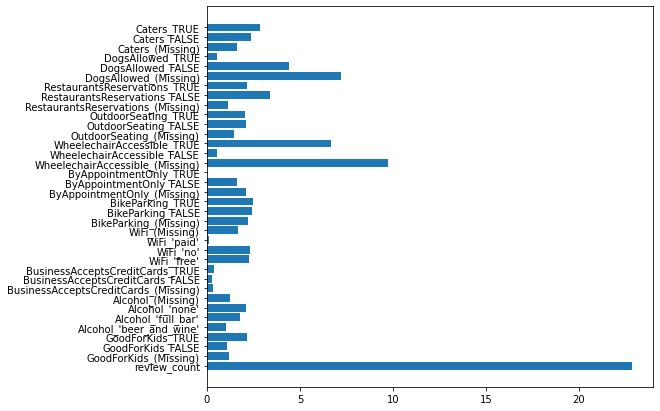

In [207]:
plt.figure(figsize=(8,7))
plt.barh(x_train.columns, 100*rf_cv.best_estimator_.feature_importances_)
plt.show()